# Analysis of the obtained results

In this notebook, we will perform an analysis of the obtained results applying MusiteDeep model to the methionine-oxidation problem.

We first load the MetOx dataset:

In [42]:
load('MetOData.RData')

In [43]:
head(MetOData)

ACC,PDB,Met,Oxidable,Yd.chain,Fd.chain,Wd.chain,nY.chain,nF.chain,nW.chain,⋯,CT_M,CT_N,CT_P,CT_Q,CT_R,CT_S,CT_T,CT_V,CT_W,CT_Y
A5YKK6,4C0D,1883,No,10.6,4.8,8.6,0,2,0,⋯,22,37,38,2,14,27,8,24,155,28
A5YKK6,4C0D,1905,No,10.9,8.8,12.6,0,0,0,⋯,22,15,16,9,7,5,21,2,133,6
A5YKK6,4C0D,1996,No,8.3,11.6,14.2,0,0,0,⋯,55,6,8,18,31,47,14,11,42,40
A5YKK6,4C0D,2051,No,6.8,4.8,9.2,1,1,0,⋯,12,30,5,6,29,83,4,31,10,13
A5YKK6,4C0D,2063,No,9.8,5.8,10.5,0,1,0,⋯,25,18,14,3,17,71,22,19,257,1
A5YKK6,4C0D,2088,No,5.9,4.4,12.8,1,1,0,⋯,52,36,19,1,9,46,7,10,232,4


In [44]:
get_ids <- function(cad){
    unlist(strsplit(unlist(strsplit(cad, '[|]'))[2], '[.]'))[1]
}


test_analysis <- function(train.ids, metox.data, results.path) {
    test_acc <- ACC_ids[-train.ids]

    # Load results (previously computed with keras/theano - deep learning)
    test_results <- read.table(results.path, sep = '\t', col.names = c('id', 'pos', 'res', 'prob'))

    test_results$id <- as.character(test_results$id)

    test_res_ids <- sapply(test_results$id, get_ids)

    test_results$id <- test_res_ids

    test_results$Prediction <- factor(ifelse(test_results$prob > 0.5, 'Yes', 'No'), levels = c('Yes','No'))

    test_results <- test_results[, c('id', 'pos', 'prob', 'Prediction')]

    names(test_results) <- c('ACC', 'Met', 'Prob', 'Prediction')

    MetOData_test <- metox.data[metox.data$ACC %in% test_acc,c('ACC','Met','Oxidable')]
    
    return(list(test_results=test_results, MetOData_test=MetOData_test))
}


metrics_analysis <- function(test_results) {
    lvl <- rev(levels(test_results$Oxidable))
    tstROC <- roc(test_results$Oxidable, test_results$Prob, levels = lvl)
    bestVals <- coords(tstROC, 0.5, ret=c("accuracy", "sensitivity", "specificity", "tp", "tn", "fp", "fn"))

    tp <- bestVals[4]
    tn <- bestVals[5]
    fp <- bestVals[6]
    fn <- bestVals[7]
    precision <- tp / (tp + fp)
    # In binary classification, sensibility=recall
    recall <- tp / (tp + fn)
    mcc <- (tp * tn - fp * fn)/sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    Fmeasure <- 2 * precision * recall / (precision + recall)
    return(c(0.5, 
             tstROC$auc, 
             bestVals[1:3],
             precision,
             recall,
             mcc,
             Fmeasure
    ))
}


results_analysis_all <- function(train.ids, metox.data, results.path) {
    # Using all the methionines not marked as positive in MetOData as the negative samples
    
    res <- test_analysis(train.ids, metox.data, results.path)
    test_results <- res$test_results
    MetOData_test <- res$MetOData_test

    test_results$Oxidable <- rep(factor("No", levels = c("Yes", "No")), dim(test_results)[1])
    for (j in 1:(dim(MetOData_test)[1])){
        test_results[test_results$ACC == MetOData_test$ACC[j] & test_results$Met == MetOData_test$Met[j], 
                     'Oxidable'] <- MetOData_test$Oxidable[j]
    }

    return(metrics_analysis(test_results))
}

## Using bootstrap strategy

In [45]:
library(pROC)
library(caret)

NM_BS <- 100 # Number of boostrap repetitions

ACC_ids <- unique(MetOData$ACC)

sts <- as.data.frame(matrix(rep(0,9*NM_BS),NM_BS,9))

names(sts) <- c("cut", 
                "ROC", 
                "Acc", 
                "Sens", 
                "Spec", 
                "Prec", 
                "Recal", 
                'MCC', 
                'FMeas')

set.seed(1)
train_ids_bs <- createResample(y = ACC_ids, times = NM_BS)

In [46]:
# To compare all obtained results using bootstrap strategy and all non-positive residues as negative samples
r.names <- c('Custom ST 1 all', 'Custom STY 1 all', 'Custom STY 1 all lr=0.00075', 'Custom STY 1 all tl=0', 
             'Custom STY 1 all tl=0 lr=0.0005', 'Custom STY 1 all tl=0 lr=0.0001')
bootstrap.mean <- as.data.frame(matrix(rep(0,length(r.names)*9),length(r.names),9))
colnames(bootstrap.mean) <- names(sts)
rownames(bootstrap.mean) <- r.names
bootstrap.std <- bootstrap.mean

### Using all phosphorylation data

Using nclass=1 and STY-residues:

In [47]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.001-tl1/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [48]:
row.name <- 'Custom STY 1 all'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                 cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 all 0.5 0.8246012 0.8074669 0.6375656 0.8205609 0.2139331
                     Recal       MCC     FMeas
Custom STY 1 all 0.6375656 0.2875487 0.3187854
[1] "Std:"
                 cut        ROC        Acc       Sens       Spec       Prec
Custom STY 1 all   0 0.01743957 0.01928497 0.07592377 0.02360048 0.02810978
                      Recal        MCC      FMeas
Custom STY 1 all 0.07592377 0.03759002 0.03459311


Using nclass=1 and ST-residues:

In [49]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-ST-nclass1-lr0.001-tl1/metox_result_custom_general_ST_bs_', 
                                       i, '_custom.txt'))
}

In [50]:
row.name <- 'Custom ST 1 all'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                cut       ROC       Acc      Sens      Spec      Prec     Recal
Custom ST 1 all 0.5 0.8040518 0.7947688 0.5886838 0.8106672 0.1923297 0.5886838
                      MCC    FMeas
Custom ST 1 all 0.2481217 0.288178
[1] "Std:"
                cut        ROC        Acc      Sens       Spec       Prec
Custom ST 1 all   0 0.02018388 0.02273654 0.0842646 0.02800439 0.02589022
                    Recal        MCC      FMeas
Custom ST 1 all 0.0842646 0.03818613 0.03214135


#### Transfer-leayer and learning-rate

Using lr=0.00075:

In [51]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.00075-tl1/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [52]:
row.name <- 'Custom STY 1 all lr=0.00075'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                            cut       ROC       Acc      Sens      Spec
Custom STY 1 all lr=0.00075 0.5 0.8234521 0.7913985 0.6730122 0.8005296
                                 Prec     Recal       MCC     FMeas
Custom STY 1 all lr=0.00075 0.2058185 0.6730122 0.2877254 0.3137791
[1] "Std:"
                            cut       ROC        Acc       Sens       Spec
Custom STY 1 all lr=0.00075   0 0.0172962 0.02298818 0.06637465 0.02738629
                                  Prec      Recal        MCC      FMeas
Custom STY 1 all lr=0.00075 0.02714186 0.06637465 0.03319643 0.03253982


Using lr=0.0005:

In [53]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.0005-tl1/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [54]:
row.name <- 'Custom STY 1 all lr=0.0005'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                           cut       ROC       Acc      Sens      Spec
Custom STY 1 all lr=0.0005 0.5 0.8223466 0.7698317 0.7086364 0.7745967
                                Prec     Recal       MCC     FMeas
Custom STY 1 all lr=0.0005 0.1940997 0.7086364 0.2828418 0.3035736
[1] "Std:"
                           cut        ROC      Acc       Sens       Spec
Custom STY 1 all lr=0.0005   0 0.01831664 0.021355 0.06831434 0.02539075
                                 Prec      Recal        MCC      FMeas
Custom STY 1 all lr=0.0005 0.02473331 0.06831434 0.03366111 0.03159807


Using lr=0.00025:

In [55]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.00025-tl1/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [56]:
row.name <- 'Custom STY 1 all lr=0.00025'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                            cut       ROC       Acc      Sens      Spec
Custom STY 1 all lr=0.00025 0.5 0.8187842 0.7386868 0.7595586 0.7370128
                                 Prec     Recal       MCC     FMeas
Custom STY 1 all lr=0.00025 0.1816369 0.7595586 0.2791884 0.2922204
[1] "Std:"
                            cut        ROC        Acc       Sens       Spec
Custom STY 1 all lr=0.00025   0 0.01942725 0.03144187 0.06673926 0.03658192
                                  Prec      Recal        MCC      FMeas
Custom STY 1 all lr=0.00025 0.02213755 0.06673926 0.03158667 0.02964153


Using lr=0.00125:

In [57]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.00125-tl1/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [58]:
row.name <- 'Custom STY 1 all lr=0.00125'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                            cut       ROC       Acc      Sens      Spec
Custom STY 1 all lr=0.00125 0.5 0.8245893 0.8227456 0.5978157 0.8401295
                                 Prec     Recal       MCC     FMeas
Custom STY 1 all lr=0.00125 0.2232082 0.5978157 0.2859654 0.3227455
[1] "Std:"
                            cut       ROC        Acc       Sens       Spec
Custom STY 1 all lr=0.00125   0 0.0182265 0.01983841 0.07835088 0.02494897
                                  Prec      Recal        MCC      FMeas
Custom STY 1 all lr=0.00125 0.03207858 0.07835088 0.03831837 0.03614759


Using lr=0.0015:

In [59]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.0015-tl1/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [60]:
row.name <- 'Custom STY 1 all lr=0.0015'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                           cut       ROC       Acc      Sens      Spec
Custom STY 1 all lr=0.0015 0.5 0.8257222 0.8370374 0.5568165 0.8586624
                                Prec     Recal       MCC    FMeas
Custom STY 1 all lr=0.0015 0.2319908 0.5568165 0.2829735 0.325066
[1] "Std:"
                           cut        ROC        Acc       Sens       Spec
Custom STY 1 all lr=0.0015   0 0.01776466 0.01754049 0.07827298 0.02241656
                                 Prec      Recal        MCC      FMeas
Custom STY 1 all lr=0.0015 0.03061038 0.07827298 0.03750615 0.03361491


Using transfer-leayer=0:

In [61]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.001-tl0/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [62]:
row.name <- 'Custom STY 1 all tl=0'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                      cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 all tl=0 0.5 0.8250863 0.8423129 0.5249736 0.8667667 0.2315154
                          Recal       MCC     FMeas
Custom STY 1 all tl=0 0.5249736 0.2729259 0.3192354
[1] "Std:"
                      cut        ROC        Acc       Sens       Spec
Custom STY 1 all tl=0   0 0.01772713 0.01356486 0.07176126 0.01733374
                            Prec      Recal        MCC      FMeas
Custom STY 1 all tl=0 0.03150495 0.07176126 0.03872839 0.03512651


Using transfer-leayer=3:

In [63]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.001-tl3/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [64]:
row.name <- 'Custom STY 1 all tl=3'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                      cut       ROC      Acc      Sens     Spec      Prec
Custom STY 1 all tl=3 0.5 0.8249449 0.814032 0.6150379 0.829401 0.2168772
                          Recal       MCC     FMeas
Custom STY 1 all tl=3 0.6150379 0.2840662 0.3185954
[1] "Std:"
                      cut        ROC        Acc       Sens       Spec    Prec
Custom STY 1 all tl=3   0 0.01733322 0.02057429 0.07634665 0.02566744 0.02999
                           Recal        MCC      FMeas
Custom STY 1 all tl=3 0.07634665 0.03602866 0.03418386


Using transfer-leayer=5:

In [65]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.001-tl5/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [66]:
row.name <- 'Custom STY 1 all tl=5'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                      cut       ROC       Acc      Sens      Spec      Prec
Custom STY 1 all tl=5 0.5 0.8045615 0.8031159 0.6016179 0.8187353 0.2036052
                          Recal       MCC     FMeas
Custom STY 1 all tl=5 0.6016179 0.2646956 0.3020633
[1] "Std:"
                      cut        ROC        Acc       Sens       Spec
Custom STY 1 all tl=5   0 0.02037681 0.02553507 0.07873155 0.03094027
                            Prec      Recal        MCC     FMeas
Custom STY 1 all tl=5 0.02843163 0.07873155 0.03574793 0.0325646


Using lr=0.00025 and transfer-leayer=0:

In [67]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.00025-tl0/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [68]:
row.name <- 'Custom STY 1 all tl=0 lr=0.00025'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                                 cut       ROC      Acc      Sens      Spec
Custom STY 1 all tl=0 lr=0.00025 0.5 0.8259764 0.773412 0.6971422 0.7792468
                                      Prec     Recal       MCC     FMeas
Custom STY 1 all tl=0 lr=0.00025 0.1951391 0.6971422 0.2810113 0.3037618
[1] "Std:"
                                 cut       ROC        Acc       Sens       Spec
Custom STY 1 all tl=0 lr=0.00025   0 0.0168897 0.02281526 0.06479564 0.02672493
                                      Prec      Recal        MCC      FMeas
Custom STY 1 all tl=0 lr=0.00025 0.0266137 0.06479564 0.03498056 0.03388339


Using lr=0.00025 and transfer-leayer=3:

In [69]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.00025-tl3/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [70]:
row.name <- 'Custom STY 1 all tl=3 lr=0.00025'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                                 cut       ROC       Acc      Sens      Spec
Custom STY 1 all tl=3 lr=0.00025 0.5 0.8163936 0.7374361 0.7609788 0.7356937
                                      Prec     Recal      MCC     FMeas
Custom STY 1 all tl=3 lr=0.00025 0.1807022 0.7609788 0.278376 0.2910938
[1] "Std:"
                                 cut        ROC        Acc       Sens
Custom STY 1 all tl=3 lr=0.00025   0 0.01836849 0.02604458 0.06960389
                                       Spec       Prec      Recal        MCC
Custom STY 1 all tl=3 lr=0.00025 0.03073273 0.02234326 0.06960389 0.03200867
                                      FMeas
Custom STY 1 all tl=3 lr=0.00025 0.02994433


Using lr=0.0005 and transfer-leayer=0:

In [71]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.0005-tl0/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [72]:
row.name <- 'Custom STY 1 all tl=0 lr=0.0005'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                                cut       ROC       Acc      Sens      Spec
Custom STY 1 all tl=0 lr=0.0005 0.5 0.8266711 0.8062029 0.6312281 0.8196592
                                     Prec     Recal       MCC     FMeas
Custom STY 1 all tl=0 lr=0.0005 0.2113876 0.6312281 0.2828205 0.3151541
[1] "Std:"
                                cut        ROC        Acc       Sens       Spec
Custom STY 1 all tl=0 lr=0.0005   0 0.01741502 0.01832176 0.07272588 0.02281644
                                      Prec      Recal        MCC      FMeas
Custom STY 1 all tl=0 lr=0.0005 0.02798091 0.07272588 0.03655271 0.03426471


Using lr=0.0005 and transfer-leayer=3:

In [73]:
for (i in 1:NM_BS){
    sts[i,] <- results_analysis_all(train_ids_bs[[i]], MetOData, 
                                paste0('all-phos-data/results/bs-STY-nclass1-lr0.0005-tl3/metox_result_custom_general_STY_bs_', 
                                       i, '_custom.txt'))
}

In [74]:
row.name <- 'Custom STY 1 all tl=3 lr=0.0005'
print('Mean:')
bootstrap.mean[row.name, ] <- sapply(sts,mean)
print(bootstrap.mean[row.name, ])

print('Std:')
bootstrap.std[row.name, ] <- sapply(sts,sd)
print(bootstrap.std[row.name, ])

[1] "Mean:"
                                cut       ROC       Acc      Sens      Spec
Custom STY 1 all tl=3 lr=0.0005 0.5 0.8211309 0.7738671 0.7054336 0.7792204
                                     Prec     Recal       MCC     FMeas
Custom STY 1 all tl=3 lr=0.0005 0.1967774 0.7054336 0.2853578 0.3064043
[1] "Std:"
                                cut        ROC        Acc       Sens       Spec
Custom STY 1 all tl=3 lr=0.0005   0 0.01779621 0.02439123 0.07251534 0.02903637
                                      Prec      Recal       MCC      FMeas
Custom STY 1 all tl=3 lr=0.0005 0.02462341 0.07251534 0.0335961 0.03097619


### Final results

In [75]:
# Compare the results obtained using default values of the learning rate (lr=0.001) and the transfer-leayer (tl=1)

model.names <- c('Custom ST 1 all', 'Custom STY 1 all')

# Mean values
bootstrap.mean[model.names, ]

# Std values
bootstrap.std[model.names, ]

,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom ST 1 all,0.5,0.8040518,0.7947688,0.5886838,0.8106672,0.1923297,0.5886838,0.2481217,0.2881780
Custom STY 1 all,0.5,0.8246012,0.8074669,0.6375656,0.8205609,0.2139331,0.6375656,0.2875487,0.3187854


,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom ST 1 all,0,0.02018388,0.02273654,0.08426460,0.02800439,0.02589022,0.08426460,0.03818613,0.03214135
Custom STY 1 all,0,0.01743957,0.01928497,0.07592377,0.02360048,0.02810978,0.07592377,0.03759002,0.03459311


In [76]:
# To produce the Table results in the paper

residues.name <- c('Custom ST 1 all', 'Custom STY 1 all')
metrics.name <- c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')

bm <- bootstrap.mean[residues.name, metrics.name]
bd <- bootstrap.std[residues.name, metrics.name]
m <- matrix(paste(as.matrix(round(bm, 4)), as.matrix(round(bd, 4))), ncol = ncol(bm), nrow = nrow(bm))
rownames(m) <- rownames(bm)
colnames(m) <- colnames(bm)
m

,ROC,Acc,Sens,Spec,FMeas,MCC
Custom ST 1 all,0.8041 0.0202,0.7948 0.0227,0.5887 0.0843,0.8107 0.028,0.2882 0.0321,0.2481 0.0382
Custom STY 1 all,0.8246 0.0174,0.8075 0.0193,0.6376 0.0759,0.8206 0.0236,0.3188 0.0346,0.2875 0.0376


In [77]:
# Compare the results obtained using different values of learning-rate

lr.names <- c('Custom STY 1 all lr=0.0015', 'Custom STY 1 all lr=0.00125', 'Custom STY 1 all', 
              'Custom STY 1 all lr=0.00075', 'Custom STY 1 all lr=0.0005', 'Custom STY 1 all lr=0.00025')

# Mean values
bootstrap.mean[lr.names, ]

# Std values
bootstrap.std[lr.names, ]

,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1 all lr=0.0015,0.5,0.8257222,0.8370374,0.5568165,0.8586624,0.2319908,0.5568165,0.2829735,0.3250660
Custom STY 1 all lr=0.00125,0.5,0.8245893,0.8227456,0.5978157,0.8401295,0.2232082,0.5978157,0.2859654,0.3227455
Custom STY 1 all,0.5,0.8246012,0.8074669,0.6375656,0.8205609,0.2139331,0.6375656,0.2875487,0.3187854
Custom STY 1 all lr=0.00075,0.5,0.8234521,0.7913985,0.6730122,0.8005296,0.2058185,0.6730122,0.2877254,0.3137791
Custom STY 1 all lr=0.0005,0.5,0.8223466,0.7698317,0.7086364,0.7745967,0.1940997,0.7086364,0.2828418,0.3035736
Custom STY 1 all lr=0.00025,0.5,0.8187842,0.7386868,0.7595586,0.7370128,0.1816369,0.7595586,0.2791884,0.2922204


,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1 all lr=0.0015,0,0.01776466,0.01754049,0.07827298,0.02241656,0.03061038,0.07827298,0.03750615,0.03361491
Custom STY 1 all lr=0.00125,0,0.01822650,0.01983841,0.07835088,0.02494897,0.03207858,0.07835088,0.03831837,0.03614759
Custom STY 1 all,0,0.01743957,0.01928497,0.07592377,0.02360048,0.02810978,0.07592377,0.03759002,0.03459311
Custom STY 1 all lr=0.00075,0,0.01729620,0.02298818,0.06637465,0.02738629,0.02714186,0.06637465,0.03319643,0.03253982
Custom STY 1 all lr=0.0005,0,0.01831664,0.02135500,0.06831434,0.02539075,0.02473331,0.06831434,0.03366111,0.03159807
Custom STY 1 all lr=0.00025,0,0.01942725,0.03144187,0.06673926,0.03658192,0.02213755,0.06673926,0.03158667,0.02964153


In [78]:
# To produce the Table results in the paper

lr.names <- c('Custom STY 1 all lr=0.00025', 'Custom STY 1 all lr=0.0005', 'Custom STY 1 all lr=0.00075', 
              'Custom STY 1 all', 'Custom STY 1 all lr=0.00125', 'Custom STY 1 all lr=0.0015')

metric.names <- c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')

bm <- bootstrap.mean[lr.names, metric.names]
bd <- bootstrap.std[lr.names, metric.names]

m <- matrix(paste(as.matrix(round(bm, 4)), as.matrix(round(bd, 4))), ncol = ncol(bm), nrow = nrow(bm))
rownames(m) <- rownames(bm)
colnames(m) <- colnames(bm)
m

,ROC,Acc,Sens,Spec,FMeas,MCC
Custom STY 1 all lr=0.00025,0.8188 0.0194,0.7387 0.0314,0.7596 0.0667,0.737 0.0366,0.2922 0.0296,0.2792 0.0316
Custom STY 1 all lr=0.0005,0.8223 0.0183,0.7698 0.0214,0.7086 0.0683,0.7746 0.0254,0.3036 0.0316,0.2828 0.0337
Custom STY 1 all lr=0.00075,0.8235 0.0173,0.7914 0.023,0.673 0.0664,0.8005 0.0274,0.3138 0.0325,0.2877 0.0332
Custom STY 1 all,0.8246 0.0174,0.8075 0.0193,0.6376 0.0759,0.8206 0.0236,0.3188 0.0346,0.2875 0.0376
Custom STY 1 all lr=0.00125,0.8246 0.0182,0.8227 0.0198,0.5978 0.0784,0.8401 0.0249,0.3227 0.0361,0.286 0.0383
Custom STY 1 all lr=0.0015,0.8257 0.0178,0.837 0.0175,0.5568 0.0783,0.8587 0.0224,0.3251 0.0336,0.283 0.0375


In [79]:
library("ggplot2")
library("tidyr")

# You only have to name your vectors as :
# 'lr' for learning rate 
# 'sensitivity' for sensitivity mean
# 'dt_sens' for sensitivity standard deviation
# 'specificity' for specificity mean
# 'dt_sp' for specificity standard deviation


lr <- seq(from = 0.00025, to = 0.0015, by = 0.00025)

model.config <- c('Custom STY 1 all lr=0.00025', 'Custom STY 1 all lr=0.0005', 'Custom STY 1 all lr=0.00075', 
                  'Custom STY 1 all', 'Custom STY 1 all lr=0.00125', 'Custom STY 1 all lr=0.0015')

dt.mean <- bootstrap.mean[model.config, ]

dt.std <- bootstrap.std[model.config, ]

AUC <- dt.mean[, 'ROC']
dt_auc <- dt.std[, 'ROC']

Sensitivity <- dt.mean[, 'Sens']
dt_sens <- dt.std[, 'Sens']

Specificity <- dt.mean[, 'Spec']
dt_sp <- dt.std[, 'Spec']

to_plot_wide <- data.frame(lr, AUC, Sensitivity, Specificity)
to_plot_large <- gather(to_plot_wide, Measure, measure_mean,
                        AUC:Specificity)
to_plot_large$dt <- c(dt_auc, dt_sens, dt_sp)

Saving 6.67 x 6.67 in image


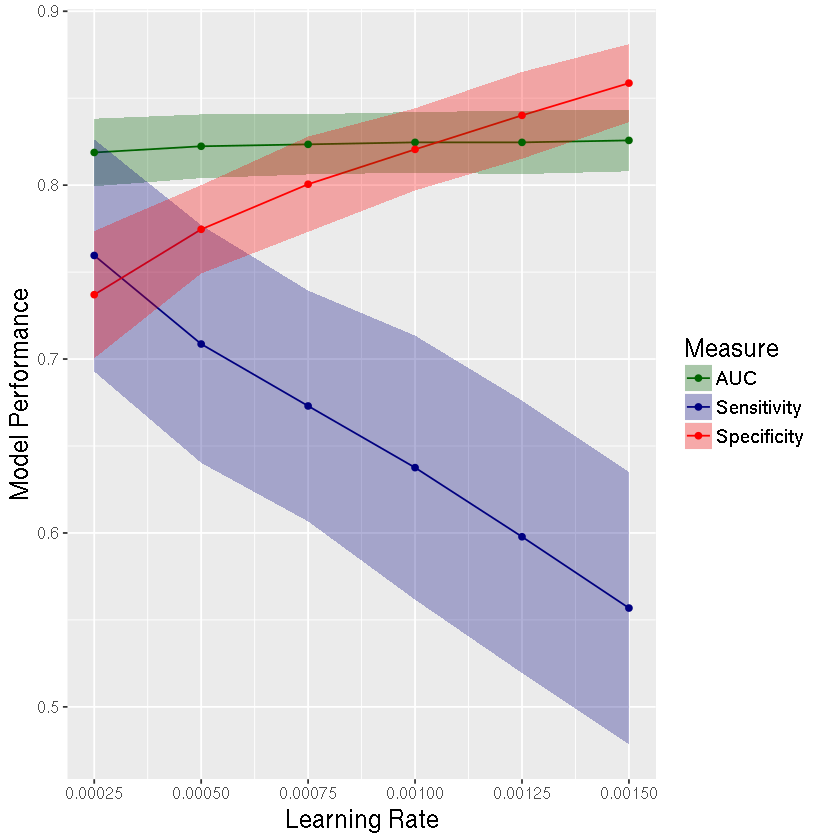

In [80]:
# Continuous plot

ggplot(to_plot_large, aes(lr, measure_mean,  group = Measure,  color = Measure)) +
  geom_line() + 
  geom_ribbon(aes(ymin=measure_mean-dt, ymax=measure_mean+dt, fill=Measure),
              linetype="blank",
              alpha=0.3) +
  geom_point() +
  scale_fill_manual(values=c("darkgreen", "navyblue", "red")) + # change shadow color here 
  scale_colour_manual(values=c("darkgreen", "navyblue", "red")) + # change line color here
  labs(x = "Learning Rate", y = "Model Performance") +
  theme(axis.title = element_text(size=15),
        axis.text = element_text(size=11),
        legend.title=element_text(size=15),
        legend.text=element_text(size=13)) +
  scale_x_continuous(labels = function(x) gsub(',', '.', sprintf("%.5f", x)), 
      limits = c(lr[1], lr[length(lr)]), breaks = lr) +
  scale_y_continuous(labels = function(x) gsub(',', '.', x)) +
  ggsave("./LR_comparison_colour.pdf")

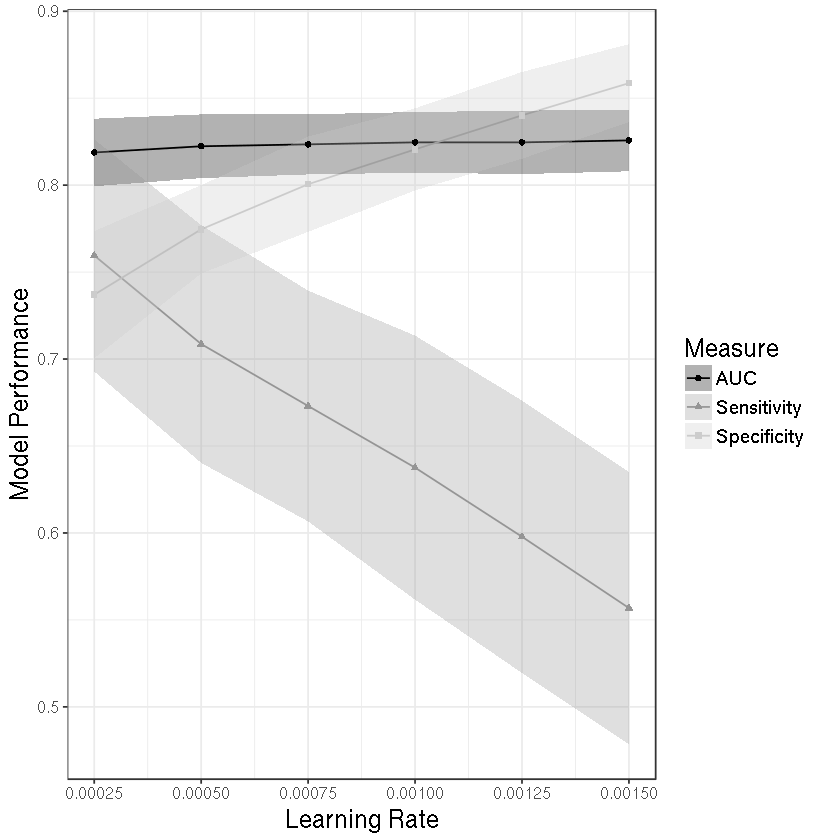

In [107]:
# Continuous plot

ggplot(to_plot_large, aes(lr, measure_mean,  group = Measure,  color = Measure)) +
  geom_line() + 
  geom_ribbon(aes(ymin=measure_mean-dt, ymax=measure_mean+dt, fill=Measure),
              linetype="blank",
              alpha=0.3) +
  geom_point(aes(shape=Measure)) +
  scale_fill_grey(start = 0, end = .8) + # change shadow color here 
  scale_colour_grey(start = 0, end = .8) + # change line color here
  theme_bw() +
  labs(x = "Learning Rate", y = "Model Performance") +
  theme(axis.title = element_text(size=15),
        axis.text = element_text(size=11),
        legend.title=element_text(size=15),
        legend.text=element_text(size=13)) +
  scale_x_continuous(labels = function(x) gsub(',', '.', sprintf("%.5f", x)), 
      limits = c(lr[1], lr[length(lr)]), breaks = lr) +
  scale_y_continuous(labels = function(x) gsub(',', '.', x)) +
  theme(text=element_text(family="Helvetica"))# +
  #ggsave("./LR_comparison_gray_scale_8_legend_serif.pdf")

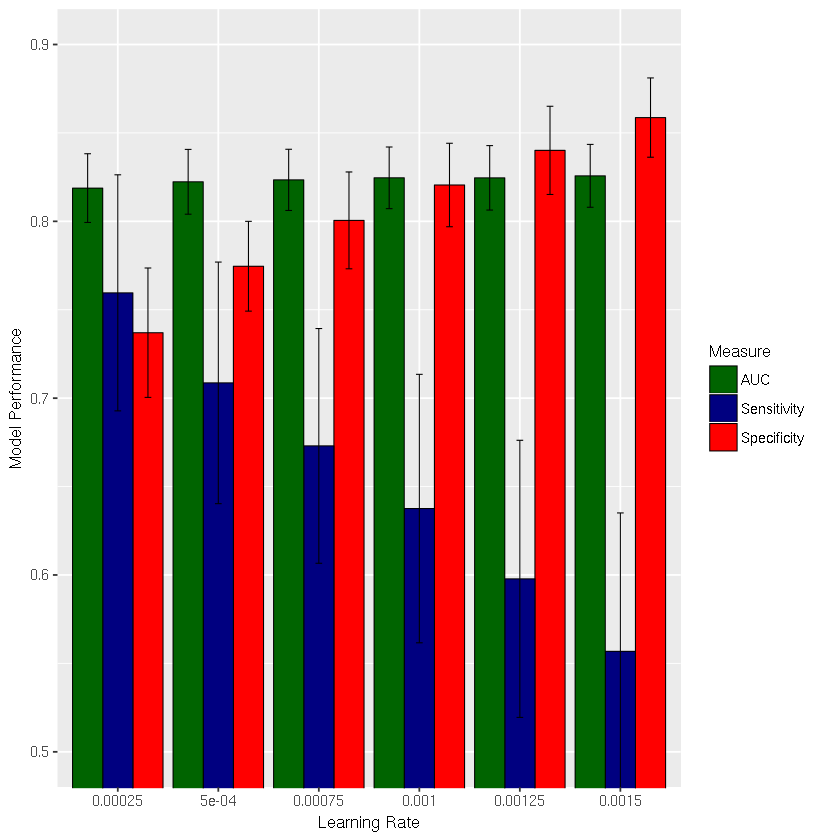

In [40]:
# Barplot

ggplot(to_plot_large, aes(factor(lr), measure_mean,  fill = Measure,  color = Measure)) +
  geom_bar(stat="identity", position=position_dodge(), 
           colour="black", size=.3) +
  geom_errorbar(aes(ymin=measure_mean-dt, ymax=measure_mean+dt),
                size=.3, width=.2, colour="black",
                position=position_dodge(.9)) +
  scale_fill_manual(values=c("darkgreen", "navyblue", "red")) + # change shadow color here 
  scale_colour_manual(values=c("darkgreen", "navyblue", "red")) + # change line color here
  labs(x = "Learning Rate", y = "Model Performance") +
  coord_cartesian(ylim = c(0.5, 0.9)) 

In [41]:
# Compare the results obtained using different values of transfer-leayer

tl.names <- c('Custom STY 1 all', 'Custom STY 1 all tl=0', 'Custom STY 1 all tl=3', 'Custom STY 1 all tl=5')

# Mean values
bootstrap.mean[tl.names, ]

# Std values
bootstrap.std[tl.names, ]

,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1 all,0.5,0.8246012,0.8074669,0.6375656,0.8205609,0.2139331,0.6375656,0.2875487,0.3187854
Custom STY 1 all tl=0,0.5,0.8250863,0.8423129,0.5249736,0.8667667,0.2315154,0.5249736,0.2729259,0.3192354
Custom STY 1 all tl=3,0.5,0.8249449,0.8140320,0.6150379,0.8294010,0.2168772,0.6150379,0.2840662,0.3185954
Custom STY 1 all tl=5,0.5,0.8045615,0.8031159,0.6016179,0.8187353,0.2036052,0.6016179,0.2646956,0.3020633


,cut,ROC,Acc,Sens,Spec,Prec,Recal,MCC,FMeas
Custom STY 1 all,0,0.01743957,0.01928497,0.07592377,0.02360048,0.02810978,0.07592377,0.03759002,0.03459311
Custom STY 1 all tl=0,0,0.01772713,0.01356486,0.07176126,0.01733374,0.03150495,0.07176126,0.03872839,0.03512651
Custom STY 1 all tl=3,0,0.01733322,0.02057429,0.07634665,0.02566744,0.02999000,0.07634665,0.03602866,0.03418386
Custom STY 1 all tl=5,0,0.02037681,0.02553507,0.07873155,0.03094027,0.02843163,0.07873155,0.03574793,0.03256460


In [42]:
# To produce the Table results in the paper

lr.names <- c('Custom STY 1 all tl=0', 'Custom STY 1 all', 'Custom STY 1 all tl=3', 'Custom STY 1 all tl=5')

metric.names <- c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')

bm <- bootstrap.mean[lr.names, metric.names]
bd <- bootstrap.std[lr.names, metric.names]

m <- matrix(paste(as.matrix(round(bm, 4)), as.matrix(round(bd, 4))), ncol = ncol(bm), nrow = nrow(bm))
rownames(m) <- rownames(bm)
colnames(m) <- colnames(bm)
m

,ROC,Acc,Sens,Spec,FMeas,MCC
Custom STY 1 all tl=0,0.8251 0.0177,0.8423 0.0136,0.525 0.0718,0.8668 0.0173,0.3192 0.0351,0.2729 0.0387
Custom STY 1 all,0.8246 0.0174,0.8075 0.0193,0.6376 0.0759,0.8206 0.0236,0.3188 0.0346,0.2875 0.0376
Custom STY 1 all tl=3,0.8249 0.0173,0.814 0.0206,0.615 0.0763,0.8294 0.0257,0.3186 0.0342,0.2841 0.036
Custom STY 1 all tl=5,0.8046 0.0204,0.8031 0.0255,0.6016 0.0787,0.8187 0.0309,0.3021 0.0326,0.2647 0.0357


In [43]:
# Compare different values of lr and tl

lr.names <- c('Custom STY 1 all tl=0 lr=0.00025', 'Custom STY 1 all tl=3 lr=0.00025', 
              'Custom STY 1 all tl=0 lr=0.0005', 'Custom STY 1 all tl=3 lr=0.0005')

metric.names <- c('ROC', 'Acc', 'Sens', 'Spec', 'FMeas', 'MCC')

bm <- bootstrap.mean[lr.names, metric.names]
bd <- bootstrap.std[lr.names, metric.names]
m <- matrix(paste(as.matrix(round(bm, 4)), as.matrix(round(bd, 4))), ncol = ncol(bm), nrow = nrow(bm))
rownames(m) <- rownames(bm)
colnames(m) <- colnames(bm)
m

,ROC,Acc,Sens,Spec,FMeas,MCC
Custom STY 1 all tl=0 lr=0.00025,0.826 0.0169,0.7734 0.0228,0.6971 0.0648,0.7792 0.0267,0.3038 0.0339,0.281 0.035
Custom STY 1 all tl=3 lr=0.00025,0.8164 0.0184,0.7374 0.026,0.761 0.0696,0.7357 0.0307,0.2911 0.0299,0.2784 0.032
Custom STY 1 all tl=0 lr=0.0005,0.8267 0.0174,0.8062 0.0183,0.6312 0.0727,0.8197 0.0228,0.3152 0.0343,0.2828 0.0366
Custom STY 1 all tl=3 lr=0.0005,0.8211 0.0178,0.7739 0.0244,0.7054 0.0725,0.7792 0.029,0.3064 0.031,0.2854 0.0336
